In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cityblock
warnings.filterwarnings('ignore')

In [2]:
PM10=pd.read_csv("PM10_E43.csv")
PM10.rename(columns = {'mg/m^3_43':'mg/m^3'}, inplace = True)
PM10

,DATETIME,mg/m^3
0,2019-04-02 01:00:00,15.0
1,2019-04-02 02:00:00,16.0
2,2019-04-02 03:00:00,14.0
3,2019-04-02 04:00:00,16.0
4,2019-04-02 05:00:00,21.0
...,...,...
25795,2022-03-31 20:00:00,23.0
25796,2022-03-31 21:00:00,18.0
25797,2022-03-31 22:00:00,14.0
25798,2022-03-31 23:00:00,14.0


In [3]:
PM10.describe()

,mg/m^3
count,24540.000000
mean,26.176121
std,17.255400
min,1.000000
25%,16.000000
50%,23.000000
75%,32.000000
max,564.000000


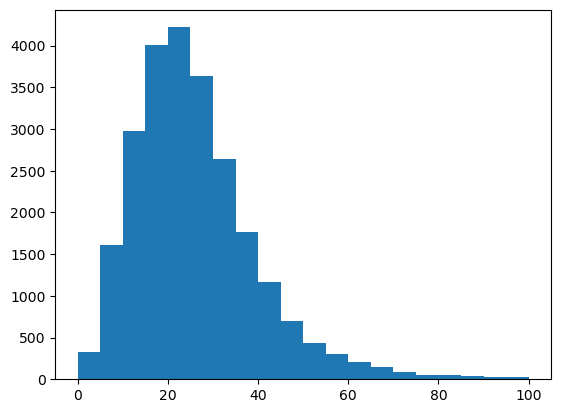

In [4]:
plt.hist(PM10["mg/m^3"],bins=20,range=(0,100))
plt.show()

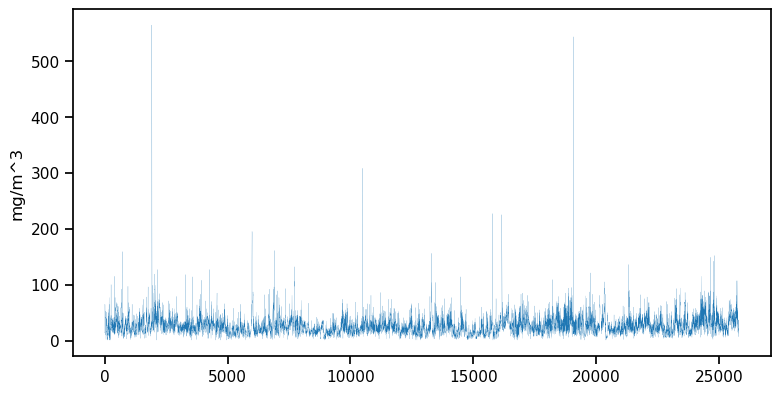

In [5]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10["mg/m^3"],linewidth=.1)
plt.show()

In [6]:
# % of missing values
PM10.count()/len(PM10)

DATETIME    1.000000
mg/m^3      0.951163
dtype: float64

In [8]:
PM10[ "mg/m^3_acum_NAN"]= 0

for j in range(1,len(PM10)):

    if PM10["mg/m^3"].isna()[j] == True :
        PM10[ "mg/m^3_acum_NAN"][j] = PM10[ "mg/m^3_acum_NAN"][j-1]+1   
        
        
    else:
        PM10[ "mg/m^3_acum_NAN"][j] = 0

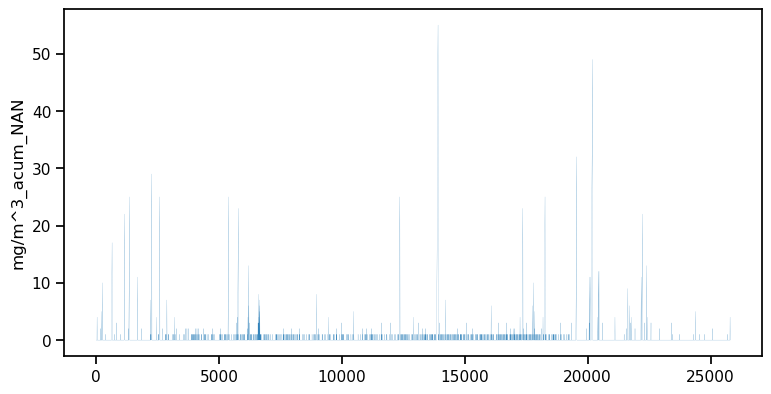

In [9]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10["mg/m^3_acum_NAN"],linewidth=.1)
plt.show()

In [10]:
PM10[ "mg/m^3_peaks_acum_NAN"]= PM10[ "mg/m^3_acum_NAN"]


for j in range(1,len(PM10)):

    if (PM10["mg/m^3_acum_NAN"][j] == 0) or (PM10["mg/m^3_acum_NAN"][j+1] > 0) :
          
        PM10[ "mg/m^3_peaks_acum_NAN"][j] = 0

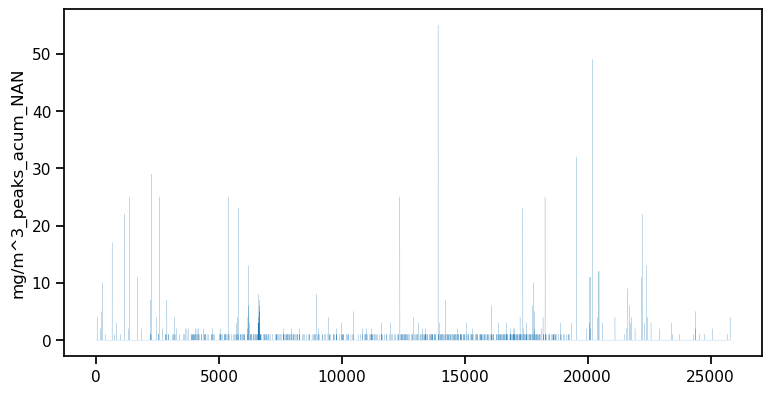

In [11]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10["mg/m^3_peaks_acum_NAN"],linewidth=.1)
plt.show()

In [12]:
PM10["mg/m^3_peaks_acum_NAN"].value_counts().sort_index()

0     25247
1       435
2        40
3        22
4        15
5         5
6         5
7         4
8         2
9         1
10        2
11        4
12        2
13        2
17        1
22        2
23        2
25        5
29        1
32        1
49        1
55        1
Name: mg/m^3_peaks_acum_NAN, dtype: int64

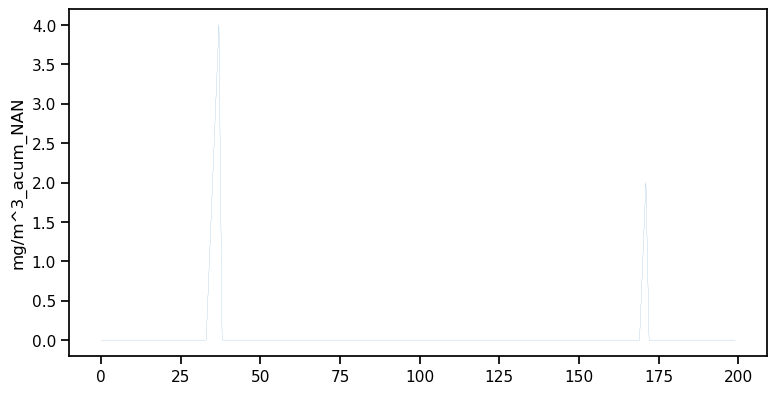

In [13]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10[:200]["mg/m^3_acum_NAN"],linewidth=.1)
plt.show()

In [14]:
PM10["mg/m^3_im"] = PM10["mg/m^3"].fillna(PM10["mg/m^3"].mean())
PM10

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im
0,2019-04-02 01:00:00,15.0,0,0,15.0
1,2019-04-02 02:00:00,16.0,0,0,16.0
2,2019-04-02 03:00:00,14.0,0,0,14.0
3,2019-04-02 04:00:00,16.0,0,0,16.0
4,2019-04-02 05:00:00,21.0,0,0,21.0
...,...,...,...,...,...
25795,2022-03-31 20:00:00,23.0,0,0,23.0
25796,2022-03-31 21:00:00,18.0,0,0,18.0
25797,2022-03-31 22:00:00,14.0,0,0,14.0
25798,2022-03-31 23:00:00,14.0,0,0,14.0


In [15]:
PM10["mg/m^3_im_24h"] = np.nan

for j in range(23, len(PM10)):

    PM10[ "mg/m^3_im_24h"][j] = PM10["mg/m^3_im"][j-23:j+1].mean()
    
PM10

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im,mg/m^3_im_24h
0,2019-04-02 01:00:00,15.0,0,0,15.0,NaN
1,2019-04-02 02:00:00,16.0,0,0,16.0,NaN
2,2019-04-02 03:00:00,14.0,0,0,14.0,NaN
3,2019-04-02 04:00:00,16.0,0,0,16.0,NaN
4,2019-04-02 05:00:00,21.0,0,0,21.0,NaN
...,...,...,...,...,...,...
25795,2022-03-31 20:00:00,23.0,0,0,23.0,23.654353
25796,2022-03-31 21:00:00,18.0,0,0,18.0,22.946020
25797,2022-03-31 22:00:00,14.0,0,0,14.0,21.987687
25798,2022-03-31 23:00:00,14.0,0,0,14.0,21.112687


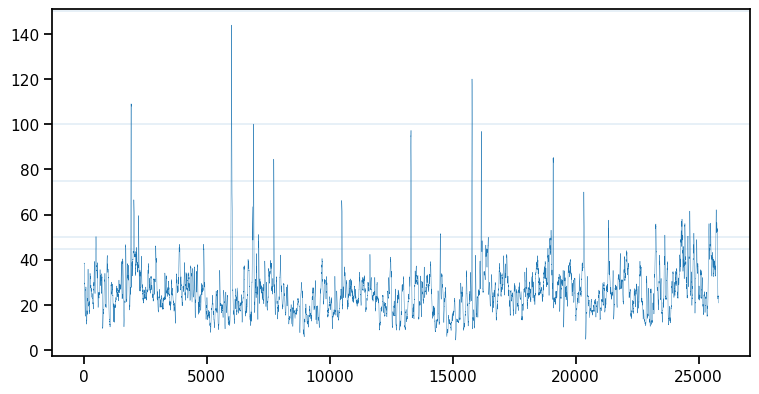

In [16]:
plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#graph = sns.lineplot(data=NO2["mg/m^3_43_24h"],linewidth=.1)

graph = plt.plot(PM10["mg/m^3_im_24h"],linewidth=.3)

plt.axhline(y=150,linewidth=.15)
plt.axhline(y=100,linewidth=.15)
plt.axhline(y=75,linewidth=.15)
plt.axhline(y=50,linewidth=.15)
plt.axhline(y=45,linewidth=.15)

plt.show()

In [17]:
PM10["mg/m^3_im_1y"] = np.nan

for j in range(8759, len(PM10)):

    PM10[ "mg/m^3_im_1y"][j] = PM10["mg/m^3_im"][j-8759:j+1].mean()
    
PM10

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im,mg/m^3_im_24h,mg/m^3_im_1y
0,2019-04-02 01:00:00,15.0,0,0,15.0,NaN,NaN
1,2019-04-02 02:00:00,16.0,0,0,16.0,NaN,NaN
2,2019-04-02 03:00:00,14.0,0,0,14.0,NaN,NaN
3,2019-04-02 04:00:00,16.0,0,0,16.0,NaN,NaN
4,2019-04-02 05:00:00,21.0,0,0,21.0,NaN,NaN
...,...,...,...,...,...,...,...
25795,2022-03-31 20:00:00,23.0,0,0,23.0,23.654353,28.394524
25796,2022-03-31 21:00:00,18.0,0,0,18.0,22.946020,28.393154
25797,2022-03-31 22:00:00,14.0,0,0,14.0,21.987687,28.391442
25798,2022-03-31 23:00:00,14.0,0,0,14.0,21.112687,28.389616


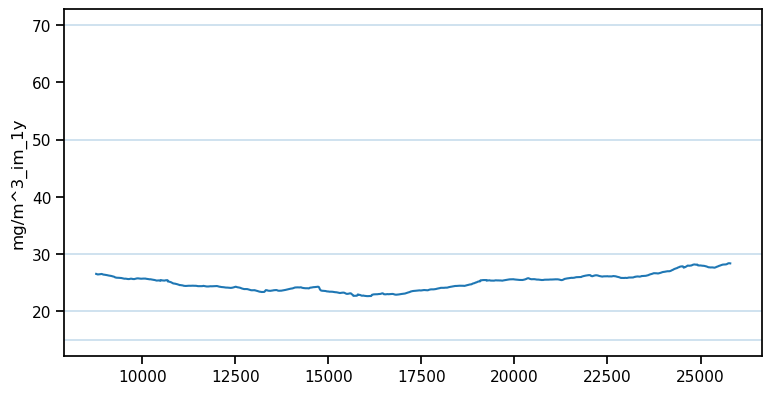

In [18]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
graph = sns.lineplot(data=PM10["mg/m^3_im_1y"])

graph.axhline(70,linewidth=.3)
graph.axhline(50,linewidth=.3)
graph.axhline(30,linewidth=.3)
graph.axhline(20,linewidth=.3)
graph.axhline(15,linewidth=.3)

plt.show()

In [19]:
size = int(len(PM10["mg/m^3_im"])*.8)

train, test = PM10["mg/m^3_im"].iloc[:size], PM10["mg/m^3_im"].iloc[size:]

In [20]:
from pmdarima.arima import auto_arima

In [21]:
step_fit = auto_arima(PM10["mg/m^3_im"],trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=186771.755, Time=35.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=189074.569, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188993.651, Time=1.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188972.657, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189072.569, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=186773.106, Time=20.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=186773.704, Time=14.84 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=186777.207, Time=22.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=186776.151, Time=20.96 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=186815.650, Time=10.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=186774.347, Time=25.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=186775.057, Time=27.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=186775.305, Time=47.49 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=186769.769, Time=13.68

In [22]:
step_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                25800
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -93379.885
Date:                Mon, 04 Jul 2022   AIC                         186769.769
Time:                        09:52:07   BIC                         186810.560
Sample:                             0   HQIC                        186782.952
                              - 25800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4543      0.035     12.948      0.000       0.386       0.523
ar.L2          0.2748      0.029      9.434      0.000       0.218       0.332
ma.L1         -0.5983      0.035    -17.136      0.000      -0.667      -0.530
ma.L2         -0.3848      0.035    -11.059      0.000      -0.453      -0.317
sigma2        81.5338      0.085    964.432      0.000      81.368      81.700
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):          26203270.71
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             4.21
Prob(H) (two-sided):                  0.00   Kurtosis:                       158.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(PM10["mg/m^3_im"],order=(2,1,2))
model = model.fit(method='mle')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mg/m^3_im   No. Observations:                25799
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -93379.877
Method:                           mle   S.D. of innovations              9.030
Date:                Mon, 04 Jul 2022   AIC                         186771.754
Time:                        09:53:27   BIC                         186820.703
Sample:                             1   HQIC                        186787.573
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0004      0.004      0.122      0.903      -0.006       0.007
ar.L1.D.mg/m^3_im     0.4556      0.128      3.561      0.000       0.205       0.706
ar.L2.D.mg/m^3_im     0.2737      0.105      2.597      0.009       0.067       0.480
ma.L1.D.mg/m^3_im    -0.5996      0.126     -4.750      0.000      -0.847      -0.352
ma.L2.D.mg/m^3_im    -0.3834      0.125     -3.063      0.002      -0.629      -0.138
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2525           +0.0000j            1.2525            0.0000
AR.2           -2.9175           +0.0000j            2.9175            0.5000
MA.1            1.0124           +0.0000j            1.0124            0.0000
MA.2           -2.5761           +0.0000j            2.5761            0.5000
-----------------------------------------------------------------------------
"""

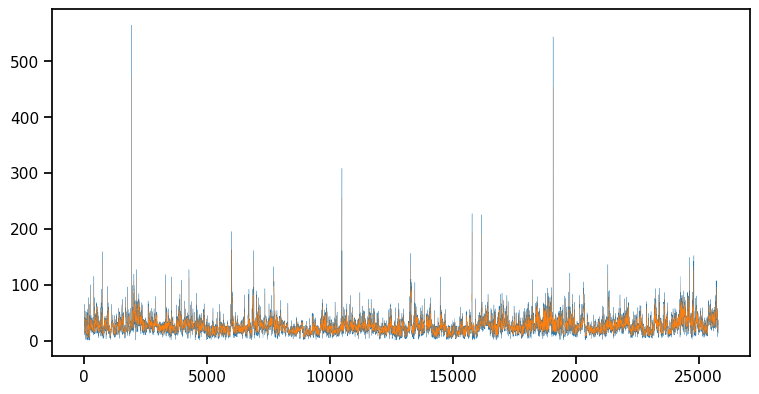

In [24]:
pred=model.predict(typ='levels')
plt.figure(figsize=(9,4.5))


plt.plot(PM10["mg/m^3_im"], linewidth =.2)
plt.plot(pred, linewidth=.1)
plt.show()